In [13]:
import pandas as pd

# Load the datasets
train_targets_path = 'data/raw_csv/A_train_targets.csv'
X_train_observed_path = 'data/raw_csv/location_a_X_train_observed.csv'
X_train_estimated_path = 'data/raw_csv/location_a_X_train_estimated.csv'
X_test_estimated_path = 'data/raw_csv/location_a_X_test_estimated.csv'

# Read the data
train_targets = pd.read_csv(train_targets_path)
X_train_observed = pd.read_csv(X_train_observed_path)
X_train_estimated = pd.read_csv(X_train_estimated_path)
X_test_estimated = pd.read_csv(X_test_estimated_path)

# Display the first few rows of each dataset
train_targets.head(), X_train_observed.head(), X_train_estimated.head(), X_test_estimated.head()


(                  time  pv_measurement
 0  2019-06-02 22:00:00            0.00
 1  2019-06-02 23:00:00            0.00
 2  2019-06-03 00:00:00            0.00
 3  2019-06-03 01:00:00            0.00
 4  2019-06-03 02:00:00           19.36,
          date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
 0  2019-06-02 22:00:00                       7.7                1.230   
 1  2019-06-02 22:15:00                       7.7                1.229   
 2  2019-06-02 22:30:00                       7.7                1.228   
 3  2019-06-02 22:45:00                       7.7                1.226   
 4  2019-06-02 23:00:00                       7.7                1.225   
 
    ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
 0                1744.9                    0.0              0.0   
 1                1734.0                    0.0              0.0   
 2                1723.5                    0.0              0.0   
 3                1713.4                 

In [14]:
# Convert time-related columns to datetime format
train_targets['time'] = pd.to_datetime(train_targets['time'])
X_train_observed['date_forecast'] = pd.to_datetime(X_train_observed['date_forecast'])
X_train_estimated['date_forecast'] = pd.to_datetime(X_train_estimated['date_forecast'])
X_test_estimated['date_forecast'] = pd.to_datetime(X_test_estimated['date_forecast'])
X_test_estimated['date_calc'] = pd.to_datetime(X_test_estimated['date_calc'])

# Resample the weather data to have an hourly resolution.
# We can take the mean of the features within each hour as the resampled value.
X_train_observed_resampled = X_train_observed.set_index('date_forecast').resample('1H').mean().reset_index()
X_train_estimated_resampled = X_train_estimated.set_index('date_forecast').resample('1H').mean().reset_index()
X_test_estimated_resampled = X_test_estimated.set_index('date_forecast').resample('1H').mean().reset_index()

# Display the first few rows of the resampled datasets
X_train_observed_resampled.head(), X_train_estimated_resampled.head(), X_test_estimated_resampled.head()


C:\Users\Bruker\AppData\Local\Temp\ipykernel_11972\3308303713.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  X_train_estimated_resampled = X_train_estimated.set_index('date_forecast').resample('1H').mean().reset_index()
C:\Users\Bruker\AppData\Local\Temp\ipykernel_11972\3308303713.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  X_test_estimated_resampled = X_test_estimated.set_index('date_forecast').resample('1H').mean().reset_index()


(        date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
 0 2019-06-02 22:00:00                     7.700              1.22825   
 1 2019-06-02 23:00:00                     7.700              1.22350   
 2 2019-06-03 00:00:00                     7.875              1.21975   
 3 2019-06-03 01:00:00                     8.425              1.21800   
 4 2019-06-03 02:00:00                     8.950              1.21800   
 
    ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
 0              1728.950                   0.00             0.00   
 1              1689.825                   0.00             0.00   
 2              1563.225                   0.00             0.00   
 3              1283.425                 208.65             0.75   
 4              1003.500               32468.15            23.10   
 
    cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
 0          1728.950              0.0         280.300          0.000  ...

In [15]:
# Check for missing values in the datasets
missing_values = {
    "train_targets": train_targets.isnull().sum(),
    "X_train_observed_resampled": X_train_observed_resampled.isnull().sum(),
    "X_train_estimated_resampled": X_train_estimated_resampled.isnull().sum(),
    "X_test_estimated_resampled": X_test_estimated_resampled.isnull().sum(),
}

# Display columns with missing values
missing_values_summary = {dataset: series[series > 0] for dataset, series in missing_values.items() if series.sum() > 0}
missing_values_summary


{'X_train_observed_resampled': ceiling_height_agl:m     5202
 cloud_base_agl:m         1868
 snow_density:kgm3       28980
 dtype: int64,
 'X_train_estimated_resampled': absolute_humidity_2m:gm3            24
 air_density_2m:kgm3                 24
 ceiling_height_agl:m               950
 clear_sky_energy_1h:J               24
 clear_sky_rad:W                     24
 cloud_base_agl:m                   520
 dew_or_rime:idx                     24
 dew_point_2m:K                      24
 diffuse_rad:W                       24
 diffuse_rad_1h:J                    24
 direct_rad:W                        24
 direct_rad_1h:J                     24
 effective_cloud_cover:p             24
 elevation:m                         24
 fresh_snow_12h:cm                   24
 fresh_snow_1h:cm                    24
 fresh_snow_24h:cm                   24
 fresh_snow_3h:cm                    24
 fresh_snow_6h:cm                    24
 is_day:idx                          24
 is_in_shadow:idx              

In [16]:
# Drop rows containing any NaN values from the datasets
X_train_observed_resampled.dropna(inplace=True)
X_train_estimated_resampled.dropna(inplace=True)
X_test_estimated_resampled.dropna(inplace=True)

# Verify if there are any missing values left in the datasets
missing_after_dropping = {
    "X_train_observed_resampled": X_train_observed_resampled.isnull().sum().sum(),
    "X_train_estimated_resampled": X_train_estimated_resampled.isnull().sum().sum(),
    "X_test_estimated_resampled": X_test_estimated_resampled.isnull().sum().sum(),
}

# Display the sum of missing values in each resampled dataset after dropping
missing_after_dropping


{'X_train_observed_resampled': 0,
 'X_train_estimated_resampled': 0,
 'X_test_estimated_resampled': 0.0}

In [17]:
# Merge the training datasets with the target dataset based on the time feature
train_observed_merged = pd.merge(train_targets, X_train_observed_resampled, left_on='time', right_on='date_forecast', how='inner')
train_estimated_merged = pd.merge(train_targets, X_train_estimated_resampled, left_on='time', right_on='date_forecast', how='inner')

# For the test dataset, we can concatenate the observed and estimated dataframes as we don't have the corresponding target values
test_merged = X_test_estimated_resampled.copy()

# Display the first few rows of the merged datasets
train_observed_merged.head(), train_estimated_merged.head(), test_merged.head()


(                 time  pv_measurement       date_forecast  \
 0 2019-12-01 09:00:00            4.40 2019-12-01 09:00:00   
 1 2019-12-01 10:00:00           66.00 2019-12-01 10:00:00   
 2 2019-12-01 11:00:00           41.80 2019-12-01 11:00:00   
 3 2019-12-01 12:00:00            4.62 2019-12-01 12:00:00   
 4 2019-12-01 13:00:00            0.00 2019-12-01 13:00:00   
 
    absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
 0                     4.800              1.27200                456.25   
 1                     4.825              1.27300                581.30   
 2                     4.800              1.27350                704.50   
 3                     4.750              1.27525                922.45   
 4                     4.650              1.27700               1301.65   
 
    clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
 0              27331.500           17.550            456.25              0.0   
 1          

# AutoML use of TPOT
We will use TPOT as the AutoML tool, which is a Python library for optimizing machine learning pipelines using genetic programming. TPOT will automatically explore hundreds of possible pipelines to find the best one for the dataset.

#### Steps:
1. Split the merged training datasets into feature matrices X and target vectors y.
2- Divide the datasets into training and validation subsets.
3. Configure TPOT and run it on the datasets to find the best model and preprocessing pipeline.
4. Evaluate the model on the validation set using Mean Absolute Error (MAE).
5. Finally, make predictions on the test dataset.
6. 
Let's start by preparing the feature matrices and target vectors and splitting them into training and validation subsets.

In [18]:
from sklearn.model_selection import train_test_split

# Prepare feature matrices (X) and target vectors (y) for both observed and estimated training datasets
X_train_observed = train_observed_merged.drop(columns=['time', 'pv_measurement', 'date_forecast'])
y_train_observed = train_observed_merged['pv_measurement']

# Split the datasets into training and validation subsets
X_train_observed_train, X_train_observed_val, y_train_observed_train, y_train_observed_val = train_test_split(
    X_train_observed, y_train_observed, test_size=0.2, random_state=42)

# Display the shapes of the training and validation subsets
(X_train_observed_train.shape, X_train_observed_val.shape, 
 y_train_observed_train.shape, y_train_observed_val.shape)


((422, 45), (106, 45), (422,), (106,))

In [19]:
%pip install tpot

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
# Initialize the TPOT Regressor with configurations
from sklearn.metrics import median_absolute_error


tpot = TPOTRegressor(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

# Run TPOT on the training subset of the observed dataset to find the best model and preprocessing pipeline
tpot.fit(X_train_observed_train, y_train_observed_train)

# Evaluate the best model on the validation subset of the observed dataset
y_pred_observed_val = tpot.predict(X_train_observed_val)
mae_observed = median_absolute_error(y_train_observed_val, y_pred_observed_val)

print(f'Mean Absolute Error on Validation Set: {mae_observed}')


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -48.85673130380222

Generation 2 - Current best internal CV score: -48.85673130380222

Generation 3 - Current best internal CV score: -48.85673130380222

Generation 4 - Current best internal CV score: -48.85673130380222

Generation 5 - Current best internal CV score: -48.85673130380222

Best pipeline: RandomForestRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.05, min_samples_leaf=9, min_samples_split=20, n_estimators=100), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=9, min_samples_split=2, n_estimators=100)
Mean Absolute Error on Validation Set: 0.00944166666666667


c:\Users\Bruker\OneDrive\NTNU semester 05\TDT4173 Maskinlæring\ml_power_predictor\venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Model Analysis


In [31]:
# Extract the trained RandomForestRegressor from TPOT
rf_model = tpot.fitted_pipeline_.steps[-1][1]

# 2. Model Parameters
model_parameters = rf_model.get_params()
print("Model Parameters:")
print(model_parameters)

# Optionally: Additional Performance Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model on other performance metrics
mse = mean_squared_error(y_train_observed_val, y_pred_observed_val)
r2 = r2_score(y_train_observed_val, y_pred_observed_val)
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"R-squared on Validation Set: {r2}")


Model Parameters:
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.7500000000000001, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Mean Squared Error on Validation Set: 12622.998970682927
R-squared on Validation Set: 0.32491499656248923


C:\Users\Bruker\AppData\Local\Temp\ipykernel_11972\3854102198.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2, color='red', label='Perfect Prediction Line')


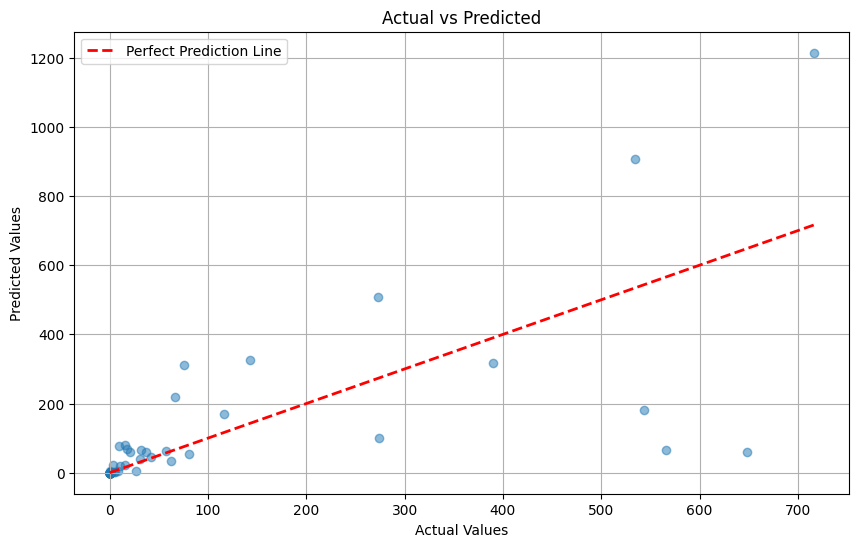

In [30]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(actual, predicted):
    plt.figure(figsize=(10,6))
    
    # Scatter plot of actual vs predicted values
    plt.scatter(actual, predicted, alpha=0.5)
    
    # Line for perfect predictions
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2, color='red', label='Perfect Prediction Line')
    
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
plot_actual_vs_predicted(y_train_observed_val, y_pred_observed_val)


# H2O's AutoML 
H2O's AutoML provides automated model selection and ensemble learning. It trains a variety of models and stacks them to produce a highly accurate ensemble.

In [34]:
%pip install h2o
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O cluster
h2o.init()

# Convert pandas DataFrame to H2OFrame
hf_train_observed = h2o.H2OFrame(train_observed_merged)
hf_train_estimated = h2o.H2OFrame(train_estimated_merged)
hf_test = h2o.H2OFrame(test_merged)  # If test_merged is already prepared

# Specify the name of the target variable in your dataset
target = 'pv_measurement'

# Run AutoML for the observed dataset
aml_observed = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
aml_observed.train(y=target, training_frame=hf_train_observed)

# View the AutoML Leaderboard for the observed dataset
lb_observed = aml_observed.leaderboard
print(lb_observed.head(rows=lb_observed.nrows))

# Predict with the leader model on the test dataset
hf_test_pred_observed = aml_observed.leader.predict(hf_test)

# If you also want to run AutoML for the estimated dataset, you can repeat the process
aml_estimated = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
aml_estimated.train(y=target, training_frame=hf_train_estimated)

# View the AutoML Leaderboard for the estimated dataset
lb_estimated = aml_estimated.leaderboard
print(lb_estimated.head(rows=lb_estimated.nrows))

# Predict with the leader model on the test dataset
hf_test_pred_estimated = aml_estimated.leader.predict(hf_test)



Note: you may need to restart the kernel to use updated packages.
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 04 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_Bruker_7ye9h9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.529 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
18:46:34.222: AutoML: XGBoost is not available; skipping it.
18:46:34.264: _train param, Dropping bad and constant columns: [dew_or_rime:idx, snow_drift:idx, prob_rime:p, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:46:34.826: _train param, Dropping bad and constant columns: [dew_or_rime:idx, snow_drift:idx, prob_rime:p, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:46:35.742: _train param, Dropping bad and constant columns: [dew_or_rime:idx, snow_drift:idx, prob_rime:p, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:46:37.89: _train param, Dropping bad and constant columns: [dew_or_rime:idx, snow_drift:idx, prob_rime:p, elevation:m, snow_densit

c:\Users\Bruker\OneDrive\NTNU semester 05\TDT4173 Maskinlæring\ml_power_predictor\venv\lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


AutoML progress: |█
18:53:38.314: AutoML: XGBoost is not available; skipping it.
18:53:38.316: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:38.434: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:38.690: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:39.141: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:39.555: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:39.836: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow_density:kgm3, wind_speed_w_1000hPa:ms]
18:53:40.251: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m, snow

In [36]:
hf_test_pred_estimated

H2OFrame is empty.

# AutoGluon
Developed by AWS, AutoGluon enables easy-to-use and easy-to-extend AutoML with a focus on deep learning and real-world applications.

In [35]:
%pip install autogluon
import autogluon.core as ag
from autogluon.tabular import TabularDataset, TabularPredictor
print("Autogluon version:", ag.__version__)
# Specify the name of the target variable in your dataset
target = 'pv_measurement'

# Load data (can be skipped if you have already prepared your DataFrames)
# train_observed_merged = pd.read_csv('path_to_your/train_observed_merged.csv')
# train_estimated_merged = pd.read_csv('path_to_your/train_estimated_merged.csv')
# test_merged = pd.read_csv('path_to_your/test_merged.csv')

# Create an AutoGluon dataset from the DataFrame (can be skipped if you have already prepared your DataFrames)
train_observed_data = TabularDataset(df=train_observed_merged)
# If train_estimated_merged is not empty
# train_estimated_data = TabularDataset(df=train_estimated_merged)
test_data = TabularDataset(df=test_merged)

# Train AutoGluon on the observed dataset
predictor_observed = TabularPredictor(label=target).fit(train_observed_data)

# Evaluate on a test dataset (optional)
# performance = predictor_observed.evaluate(test_data)

# Make predictions on the test dataset
predictions_observed = predictor_observed.predict(test_data)

# If you also want to run AutoGluon for the estimated dataset, you can repeat the process
# predictor_estimated = TabularPredictor(label=target).fit(train_estimated_data)
# predictions_estimated = predictor_estimated.predict(test_data)


^C
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'autogluon'

ERROR: Could not install packages due to an OSError: [WinError 5] Ingen tilgang: 'C:\\Users\\Bruker\\OneDrive\\NTNU semester 05\\TDT4173 Maskinlæring\\ml_power_predictor\\venv\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Check the permissions.



  Obtaining dependency information for autogluon from https://files.pythonhosted.org/packages/2e/42/f26592ecf3dc4e4edcbc5f7f7e3deba25b0681fad2ad04a82d12af17e3a4/autogluon-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.core[all]==0.8.2 from https://files.pythonhosted.org/packages/e0/56/545adb1d388e78591cd7e36de0c8b889c1944de362bdaeec0f31d01890df/autogluon.core-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.features==0.8.2 from https://files.pythonhosted.org/packages/bb/ea/7892719f78a30aee1bf42c4a0540fbae98bfbdf56b85fab79ffc437eb687/autogluon.features-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.tabular[all]==0.8.2 from https://files.pythonhosted.org/packages/f3/dc/0bd8cadb9a5e2f3e5b12caaa6745357d912ffc7b8b75fb4e426a38331028/autogluon.tabular-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.multimodal==0.8.2 from https://files.pythonhosted.org/packages/f

# LazyPredict

In [ ]:
%pip install lazypredict
from lazypredict.Supervised import LazyRegressor
lazy_model = LazyRegressor()
models, predictions = lazy_model.fit(X_train, X_test, y_train, y_test)
